In [1]:
!pip install carbontracker
!pip install codecarbon
!pip install wandb

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import wandb
import math
from wandb.integration.keras import WandbCallback


import carbontracker
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
import codecarbon
from codecarbon import EmissionsTracker
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Initialize a W&B run and set hyperparameters
wandb.login(key="d0443b4249d89fb1ed2dde3aa1dedea814f47c61")
wandb.init(
    project="MLOPS-Hackathon",   # Name of your project
    entity="emiliewedenborg-technical-university-of-denmark",  # Replace with your W&B entity
    name="temperature-forecasting-lstm",  # Name of the run

    config={
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 0.001,
        "optimizer": "adam"
    }
)

config = wandb.config

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ask-e-oren (emiliewedenborg-technical-university-of-denmark) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
data_dir = 'sample_data/DailyDelhiClimateTrain.csv'
df = pd.read_csv(data_dir)

In [6]:
df['date'] = pd.to_datetime(df['date'], format='mixed')
df.set_index('date', inplace= True)

n_cols = 1
dataset = df["meantemp"]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1462, 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [8]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [9]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 1)

In [10]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 60
n_cols = 1

for i in range(time_steps, len(scaled_data)):
    x_train.append(scaled_data[i-time_steps:i, :n_cols])
    y_train.append(scaled_data[i, :n_cols])

In [11]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [12]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))

In [13]:
# Creating a testing set with 60 time-steps and 1 output
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 1

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [14]:
n_cols = 4
cols = list(df.loc[:, ['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
dataset = df[cols]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1462, 4)

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [16]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [17]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 4)

In [18]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 60
n_cols = 4

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])

In [19]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))
x_train.shape , y_train.shape

((1036, 60, 4), (1036, 4))

In [21]:
import torch
import torch.nn as nn

class TemperatureCNN(nn.Module):
    def __init__(self, time_steps, n_cols):
        super(TemperatureCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_cols, out_channels=32, kernel_size=3, padding='same')
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        # Calculate the output size after convolutional and pooling layers to determine the input size for the first linear layer
        # This requires knowing the input time_steps and kernel/pool sizes
        # For simplicity and assuming padding='same' and stride=1 for conv layers, the size after conv is still time_steps.
        # After two max pooling layers with kernel_size=2, the size becomes time_steps // 4.
        self.flattened_size = 64 * (time_steps // 4)
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_cols)

    def forward(self, x):
        # Permute the input tensor to have shape (batch_size, channels, sequence_length)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
import torch.optim as optim

# Instantiate the PyTorch model
# Assuming time_steps and n_cols are available from previous cells
model = TemperatureCNN(time_steps, n_cols)

# Define the loss function (Mean Squared Error - MSE)
criterion = nn.MSELoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [23]:
from torch.utils.data import Dataset, DataLoader

class ClimateDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Create instances of the custom Dataset
train_dataset = ClimateDataset(x_train, y_train)
# For the test set, we need to adjust the data preparation slightly as x_test and y_test were created for the single column case.
# Recreate x_test and y_test for the 4-column case.
time_steps = 60
test_data = scaled_data[train_size - time_steps:, :]

x_test_new = []
y_test_new = []
n_cols = 4

for i in range(time_steps, len(test_data)):
    x_test_new.append(test_data[i-time_steps:i, 0:n_cols])
    y_test_new.append(test_data[i, 0:n_cols])
x_test_new, y_test_new = np.array(x_test_new), np.array(y_test_new)
x_test_new = np.reshape(x_test_new, (x_test_new.shape[0], x_test_new.shape[1], n_cols))

test_dataset = ClimateDataset(x_test_new, y_test_new)

# Create DataLoader instances
batch_size = config.batch_size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = config.epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Log training loss to Wandb
    wandb.log({"train_loss": running_loss / len(train_dataloader), "epoch": epoch})

    # Evaluation loop
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    # Log test loss to Wandb
    wandb.log({"test_loss": test_loss / len(test_dataloader), "epoch": epoch})

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss / len(train_dataloader):.4f}, Test Loss: {test_loss / len(test_dataloader):.4f}")

print("Finished Training")

Epoch 1/100, Train Loss: 0.0840, Test Loss: 0.0291
Epoch 2/100, Train Loss: 0.0277, Test Loss: 0.0163
Epoch 3/100, Train Loss: 0.0206, Test Loss: 0.0123
Epoch 4/100, Train Loss: 0.0169, Test Loss: 0.0105
Epoch 5/100, Train Loss: 0.0160, Test Loss: 0.0090
Epoch 6/100, Train Loss: 0.0145, Test Loss: 0.0094
Epoch 7/100, Train Loss: 0.0139, Test Loss: 0.0097
Epoch 8/100, Train Loss: 0.0133, Test Loss: 0.0086
Epoch 9/100, Train Loss: 0.0134, Test Loss: 0.0101
Epoch 10/100, Train Loss: 0.0124, Test Loss: 0.0100
Epoch 11/100, Train Loss: 0.0125, Test Loss: 0.0086
Epoch 12/100, Train Loss: 0.0116, Test Loss: 0.0098
Epoch 13/100, Train Loss: 0.0114, Test Loss: 0.0132
Epoch 14/100, Train Loss: 0.0112, Test Loss: 0.0112
Epoch 15/100, Train Loss: 0.0102, Test Loss: 0.0108
Epoch 16/100, Train Loss: 0.0104, Test Loss: 0.0106
Epoch 17/100, Train Loss: 0.0099, Test Loss: 0.0121
Epoch 18/100, Train Loss: 0.0094, Test Loss: 0.0093
Epoch 19/100, Train Loss: 0.0094, Test Loss: 0.0110
Epoch 20/100, Train L

In [25]:
@torch.no_grad()
def evaluate(model, dataloader, criterion=nn.MSELoss(), verbose=True):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    if verbose:
        print(f"Evaluation Loss: {avg_loss:.4f}")
    return avg_loss

In [55]:
!pip install torchprofile

In [26]:
from torchprofile import profile_macs
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [27]:
from tqdm.auto import tqdm
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: loss={acc:.2f}', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: loss=[{", ".join(["{:.2f}".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [28]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    # Step 1: calculate the #zeros
    num_zeros = round(num_elements*sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold[0])

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [29]:
sparsities, accuracies = sensitivity_scan(
    model, test_dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/5 weight - conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: loss=[0.01, 0.01, 0.02, 0.02, 0.02, 0.03]

scanning 1/5 weight - conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: loss=[0.01, 0.01, 0.01, 0.01, 0.01, 0.02]

scanning 2/5 weight - fc1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: loss=[0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

scanning 3/5 weight - fc2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: loss=[0.01, 0.01, 0.01, 0.02, 0.02, 0.03]

scanning 4/5 weight - fc3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: loss=[0.02, 0.02, 0.02, 0.05, 0.09, 0.15]

In [30]:
dense_model_accuracy = evaluate(model, test_dataloader)
dense_model_size = get_model_size(model)
print(f"dense model has loss={dense_model_accuracy:.2f}")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

Evaluation Loss: 0.0093
dense model has loss=0.01
dense model has size=0.27 MiB


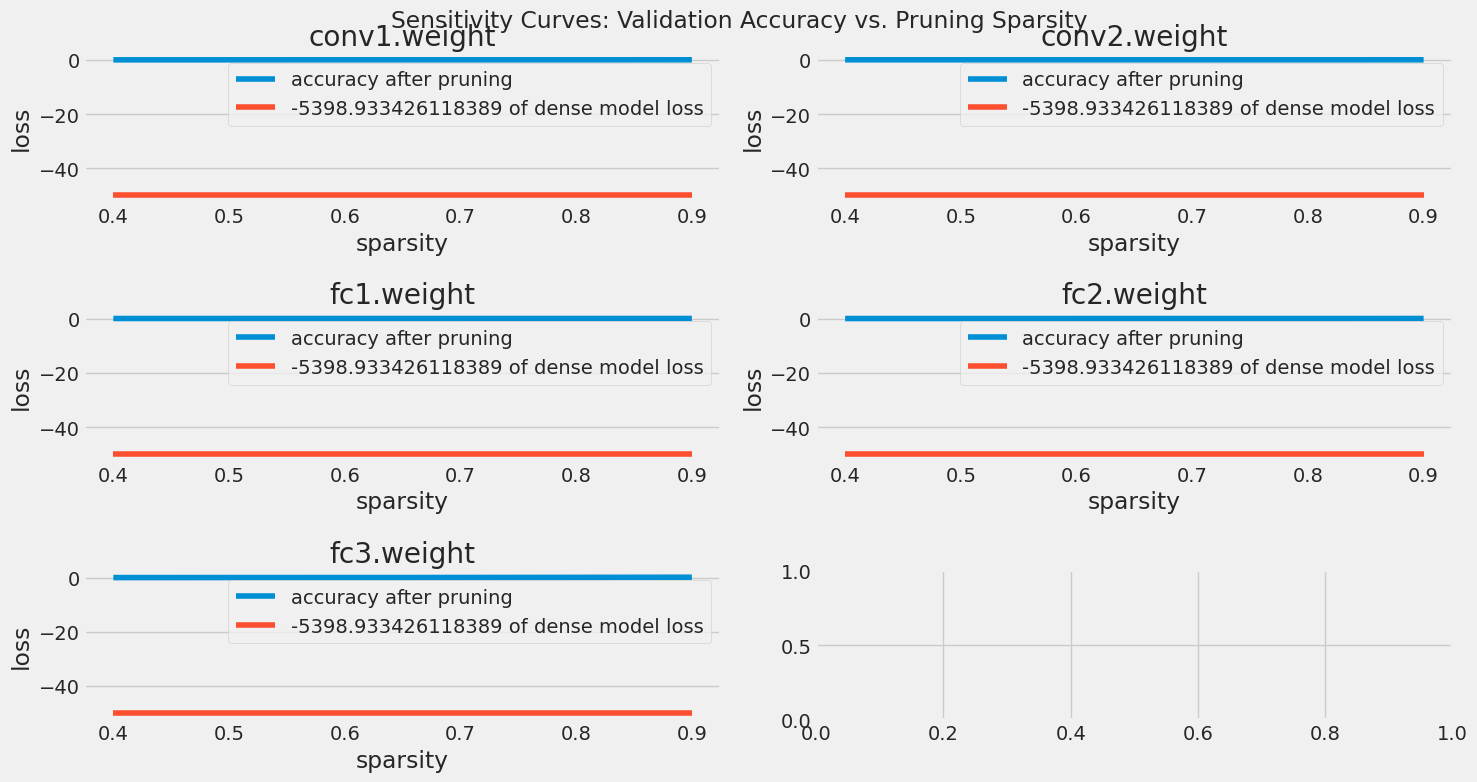

In [31]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_loss):
    lower_bound_loss = 100 - (100 - dense_model_loss) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_loss] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            #ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('loss')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_loss / dense_model_loss} of dense model loss'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

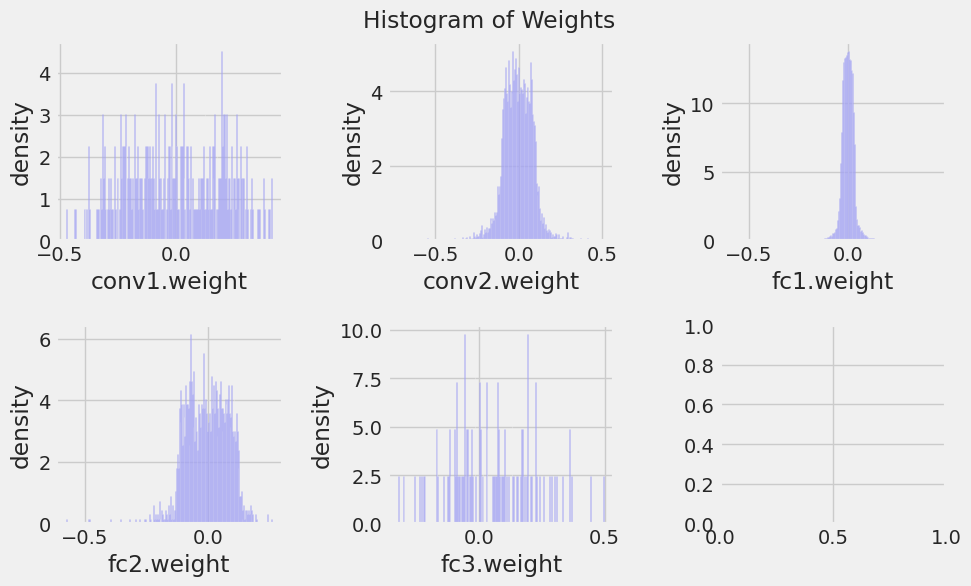

In [32]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(2,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

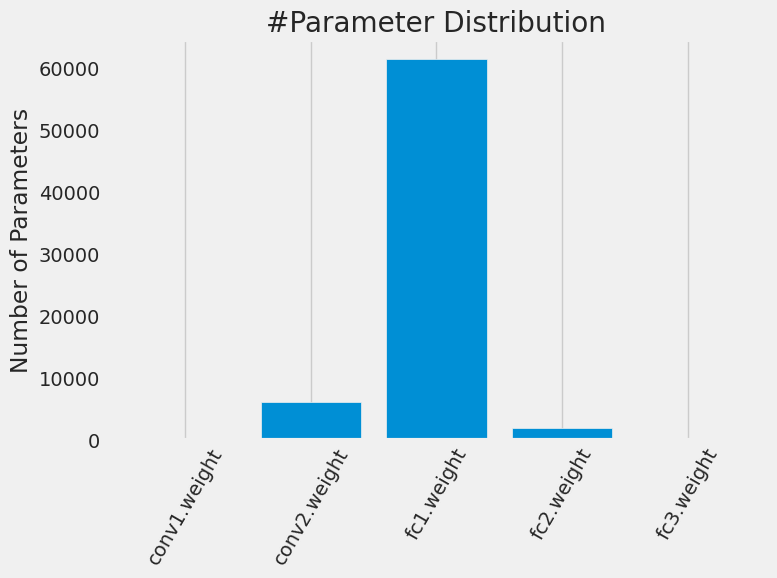

In [33]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

In [34]:
sparsity_dict = {
    'conv1.weight': 0.5,
    'conv2.weight': 0.5,
    'fc1.weight': 0.9,
    'fc2.weight': 0.6,
    'fc3.weight': 0.4,
}

In [35]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

After pruning with sparsity dictionary
  conv1.weight: 0.50
  conv2.weight: 0.50
  fc1.weight: 0.90
  fc2.weight: 0.60
  fc3.weight: 0.40
The sparsity of each layer becomes
  conv1.weight: 0.50
  conv2.weight: 0.50
  fc1.weight: 0.90
  fc2.weight: 0.60
  fc3.weight: 0.40
Sparse model has size=0.04 MiB = 14.93% of dense model size
Evaluation Loss: 0.0307
Sparse model has loss=0.03 before finetuning


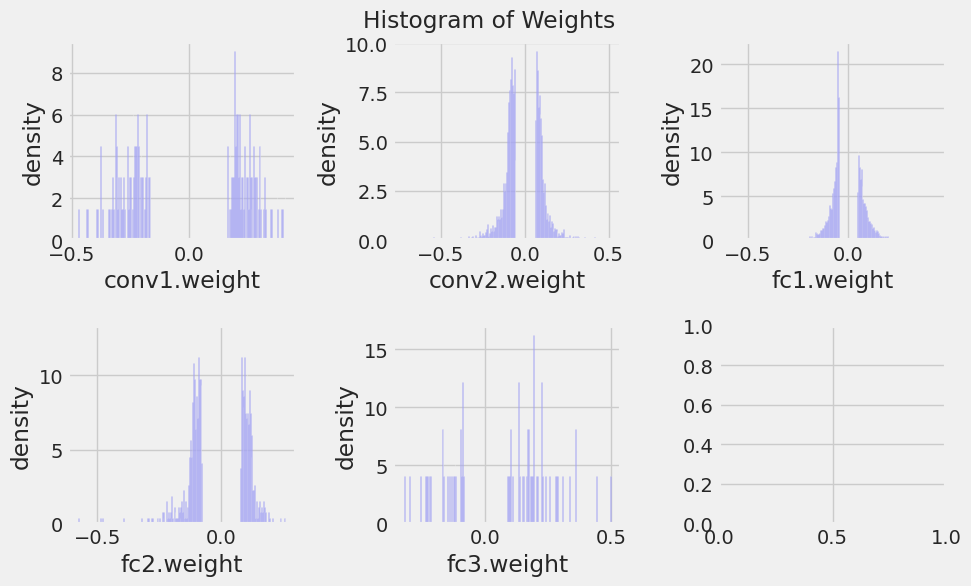

In [36]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_loss = evaluate(model, test_dataloader)
print(f"Sparse model has loss={sparse_model_loss:.2f} before finetuning")

plot_weight_distribution(model, count_nonzero_only=True)

In [37]:
def train(model, dataloader, criterion, optimizer, scheduler=None, callbacks=None):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Apply callbacks
        if callbacks:
            for callback in callbacks:
                callback()

    if scheduler:
        scheduler.step()

    return running_loss / len(dataloader)

In [38]:
import copy
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.MSELoss()

best_sparse_model_checkpoint = dict()
best_loss = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, train_dataloader, criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    loss = evaluate(model, test_dataloader)
    is_best = loss > best_loss
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_loss = loss
    print(f'    Epoch {epoch+1} loss {loss:.2f}% / Best loss: {best_loss:.2f}%')

Finetuning Fine-grained Pruned Sparse Model
Evaluation Loss: 0.0100
    Epoch 1 loss 0.01% / Best loss: 0.01%
Evaluation Loss: 0.0088
    Epoch 2 loss 0.01% / Best loss: 0.01%
Evaluation Loss: 0.0086
    Epoch 3 loss 0.01% / Best loss: 0.01%
Evaluation Loss: 0.0085
    Epoch 4 loss 0.01% / Best loss: 0.01%
Evaluation Loss: 0.0085
    Epoch 5 loss 0.01% / Best loss: 0.01%


In [39]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_loss = evaluate(model, test_dataloader)
print(f"Sparse model has loss={sparse_model_loss:.2f} after finetuning")

Sparse model has size=0.04 MiB = 14.93% of dense model size
Evaluation Loss: 0.0100
Sparse model has loss=0.01 after finetuning


In [45]:
!pip install ai_edge_torch

In [54]:
# Convert the PyTorch model to TFLite
import ai_edge_torch
from ai_edge_litert.interpreter import Interpreter
import numpy as np
import torch
from ai_edge_torch.quantize import pt2e_quantizer
from ai_edge_torch.quantize import quant_config
from torch.ao.quantization import quantize_pt2e

# Assuming a dummy input for tracing (replace with actual input shape if necessary)
# The input shape should match the input shape of your model's forward pass
# For a time series model with time_steps and n_cols, the input shape is typically (batch_size, time_steps, n_cols)
# We'll use a batch size of 1 for conversion.
dummy_input = iter(test_dataloader)

# Quantization
quantizer = pt2e_quantizer.PT2EQuantizer().set_global(
    pt2e_quantizer.get_symmetric_quantization_config()
)
model = torch._export.capture_pre_autograd_graph(model, (dummy_input,))
model = quantize_pt2e.prepare_pt2e(model, quantizer)

# Convert the model
model = quantize_pt2e.convert_pt2e(model, fold_quantize=False)

tflite_model = ai_edge_torch.convert(
    model,
    dummy_input,
    quant_config=quant_config.QuantConfig(pt2e_quantizer=quantizer),
)

# Save the TFLite model (optional)
tflite_model_path = "pytorch_cnn_pruned.tflite"
tflite_model.export(tflite_model_path)

print(f"TFLite model saved successfully as {tflite_model_path}")

# Basic example of how to load and run inference with the TFLite model
try:
    interpreter = Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Assuming a single input tensor for the model
    input_index = input_details[0]["index"]
    output_index = output_details[0]["index"]

    # Get a sample input from your test data (assuming test_dataloader is available)
    sample_input, sample_label = next(iter(test_dataloader))
    sample_input = sample_input[0].unsqueeze(0).numpy() # Take one sample and add batch dimension, convert to numpy

    # Set the tensor to the input tensor.
    interpreter.set_tensor(input_index, sample_input.astype(input_details[0]['dtype']))

    # Invoke inference.
    interpreter.invoke()

    # Get the output tensor.
    tflite_output = interpreter.get_tensor(output_index)

    print("\n--- TFLite Model Inference Example ---")
    print(f"Sample Input Shape: {sample_input.shape}")
    print(f"TFLite Output Shape: {tflite_output.shape}")
    # print(f"TFLite Output: {tflite_output}") # Uncomment to see the output

except Exception as e:
    print(f"\nError during TFLite inference example: {e}")
    print("Please ensure you have the necessary dependencies installed (e.g., tensorflow, tensorflow-lite-runtime)")

Unsupported: Observed exception

from user code:
   File "/tmp/ipython-input-3676718570.py", line 23, in forward
    x = x.permute(0, 2, 1)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


In [57]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 75.5 MB/s eta 0:00:00


In [60]:
!pip install onnx-tf

INFO: pip is looking at multiple versions of onnx-tf to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 6.1 MB/s eta 0:00:00


In [58]:
# Export the model to ONNX format
output_onnx_path = "temperature_cnn.onnx"
torch.onnx.export(model,
                  dummy_input,
                  output_onnx_path,
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the name of the input nodes
                  output_names = ['output'], # the name of the output nodes
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

print(f"Model successfully exported to {output_onnx_path}")

Model successfully exported to temperature_cnn.onnx


In [64]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load("temperature_cnn.onnx")

# Create a TensorFlow backend representation
tf_rep = prepare(onnx_model)

# Export the TensorFlow model to SavedModel format
tf_model_path = "tensorflow_model"
tf_rep.export_saved_model(tf_model_path)

print(f"TensorFlow SavedModel exported successfully to {tf_model_path}")

ModuleNotFoundError: No module named 'tensorflow_addons'

In [65]:
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load("temperature_cnn.onnx")

ModuleNotFoundError: No module named 'tensorflow_addons'